# Triangulation for sequence of images

### Libraries

In [9]:
# General
import numpy as np
import numpy.linalg as la
import pickle as pkl
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

# Image
from skimage import feature
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, FundamentalMatrixTransform, rotate
from skimage.color import rgb2gray
from skimage.measure import ransac
import cv2

### Calculating F matrix

In [10]:
def get_parameters(dino_param_df):
    """
    Read the text file to get the parmeters of interest: K, R, T
    """

    param_dict = {}

    for i in range(len(dino_param_df)):
        row = dino_param_df.loc[i]
        K = np.array(row.loc[1:9].tolist()).reshape(3,3)
        R = np.array(row.loc[10:18].tolist()).reshape(3,3)
        T = np.array(row.loc[19:].tolist()).reshape(3,1)

        # param_dict[dino_param_df.loc[i][0]] = [K, R, T]
        param_dict[i] = [K, R, T]
    
    return param_dict


def get_cross_matrix(T):
    """
    T_mat = [ 0  -a3 a2]
            [ a3  0 -a1]
            [-a2 a1  0 ]
    """
    a1, a2, a3 = T

    T_mat = np.zeros((3,3))
    T_mat[0, 1] = -a3
    T_mat[0, 2] = a2
    T_mat[1, 0] = a3
    T_mat[1, 2] = -a1
    T_mat[2, 0] = -a2
    T_mat[2, 1] = a1

    return T_mat

def get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2):
    """
    """

    P1 = K1 @ np.hstack([R1, T1])
    P2 = K2 @ np.hstack([R2, T2])

    # Calculate Pseudo-Inverse
    P1_pI = np.linalg.pinv(P1)
    
    # Camera center of the first camera
    C1 = np.linalg.solve(P1[:, :-1], -P1[:, -1])
    
    # Camera center in homogenous coordinates
    C1 = np.hstack([C1, 1])
    
    # Epipole of C1 into second image
    E2 = P2 @ C1

    # Calculate F matrix
    E2_mat = get_cross_matrix(E2)
    F_mat = E2_mat @ P2 @ P1_pI

    return F_mat

### Finding Matching Pairs

In [11]:
def sample_on_dino(imL, bounding_box_size, num_feature_points = None, dino_threshold = 0.4):
    """
    bounding_box_size must be ODD number
    """

    # SAMPLE RANDOM INDICES
    h,w,_ = np.shape(imL)

    mask_dino = np.where(np.sum(imL, axis = 2) > dino_threshold, 1, 0)
    mask_dino = np.where(mask_dino == 1)

    points = np.array([mask_dino[1], mask_dino[0]]).T

    mask_boundary = np.where((points[:, 0] > bounding_box_size)&(points[:,0] < w-bounding_box_size)& \
                                (points[:,1] > bounding_box_size)&(points[:,1] < h-bounding_box_size))
    points = points[mask_boundary] 
    
    if not num_feature_points:
        num_feature_points = len(points)
    
    idx = np.random.choice(np.arange(points.shape[0]), size = num_feature_points, replace = False)

    x1 = points[idx]
    
    return x1


def get_bound_box_intensities(im, point, bounding_box_size):
    u, v_dec = int(point[0]), point[1]
    v_ceil, v_floor = int(np.ceil(v_dec)), int(np.floor(v_dec))

    i = bounding_box_size//2

    im_cropped_list = []

    for v in [v_ceil, v_floor]:
        w_min, w_max = u - i, u + i
        h_min, h_max = v - i, v + i

        im_cropped_list.append(im[h_min:(h_max+1), w_min:(w_max+1), :])

    return im_cropped_list[0], v_ceil, im_cropped_list[1], v_floor


def loss_function_abs(image_point, image_point_2, imL_cropped, imR_cropped): # Depreciated

    # Photoconsistency (?) + (Positional Consistency)
    # Photoconsistency hovers around [0.1, 12]
    # Positional Consistency hovers around [30, 600] (divide by 100 maybe?)
    loss = 70*np.sum(np.abs(imL_cropped - imR_cropped)) + np.sum(np.linalg.norm(image_point - image_point_2))

    return loss

def loss_function_default(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    photo_con_loss = np.sum(np.abs(imL_cropped - imR_cropped))
    pos_loss = np.sum(np.abs(image_point[1] - image_point_2[1]))

    loss = photo_con_loss + 3*pos_loss

    return loss

def get_right_epipolar_line(imR, x1, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 

    x1_homo = np.append(x1, np.ones(len(x1))[:,None], axis = 1) 
    
    l2 = x1_homo @ F.T

    u = np.repeat(np.array([0, imR.shape[1]])[None,:], len(x1), axis=0) 

    v = predict_y(l2, u)

    return u, v, l2


def get_left_epipolar_line(imL, x2, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 
    
    x2_homo = np.append(x2, np.ones(len(x2))[:,None], axis = 1) 
    
    l1 = x2_homo @ F

    u = np.repeat(np.array([0, imL.shape[1]])[None,:], len(x2), axis=0) 

    v = predict_y(l1, u)

    return u, v, l1

def get_right_image_point(imL, imR, image_point, x2_on_eline, 
                               bounding_box_size, loss_function = loss_function_default):
    
    final_image_point_2_list, final_loss_list = [], []
    
    # For giving image_point and bounding_box_size return cropped array
    imL_cropped, _, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)

    for i in range(len(x2_on_eline)):
        # Testing if current point on epipolar line in image 2 works
        image_point_2 = x2_on_eline[i, :]
        
        # Return the (bounding_box_size x bounding_box_size x 3)
        imR_cropped_ceil, v_ceil, imR_cropped_floor, v_floor = \
        get_bound_box_intensities(imR, image_point_2, bounding_box_size)

        # Custom loss functino
        image_point_2_list= [np.array([image_point_2[0], v_ceil]), np.array([image_point_2[0], v_floor])]
        
        # bb_int_L[0] = bb_int_L[1] since the image_point are all ints to begin with
        loss_list = [loss_function(image_point, image_point_2_list[0], imL_cropped, imR_cropped_ceil), \
                        loss_function(image_point, image_point_2_list[1], imL_cropped, imR_cropped_floor)]

        loss_arg = np.argmin(loss_list)
        
        image_point_2 = image_point_2_list[loss_arg]
        loss = loss_list[loss_arg]
        
        final_image_point_2_list.append(image_point_2)
        final_loss_list.append(loss)
    
    final_R_point = final_image_point_2_list[np.argmin(final_loss_list)]

    return final_R_point

def get_right_image_point_cv(imL, imR, impts, x2_on_eline = None, shift = None,
                               bbr = 5, epsilon = 0, method = cv2.TM_CCOEFF_NORMED,
                               show_img = False):

    h, w = bbr*2+1, bbr*2+1
    x, y = impts
    img = imR.copy()
    img_ref = imL.copy()
    if not shift: # Define horizontal shift
        shift = (-bbr, bbr)
        
    # Get template from imL
    imL_padded = np.pad(imL, [(bbr, bbr), (bbr, bbr), (0, 0)], mode='constant')
    template = imL_padded[y:y+h, x:x+w, :]

    result = cv2.matchTemplate(img, template, method)
    result_padded = np.pad(result, [(bbr, bbr), (bbr, bbr)], mode='constant')

    # return location with max score along x2 lines
    shift_template = np.repeat(np.array([0, 1])[None, :], x2_on_eline.shape[0], axis = 0)
    shift_diff = shift[1] - shift[0] + 1
    result_eline = np.zeros((shift_diff, x2_on_eline.shape[0]))

    for s in range(shift[0], shift[1]):
        x2_eline_shifted = x2_on_eline + shift_template * s
        x2_eline_shifted = np.where(x2_eline_shifted < 0, 0, x2_eline_shifted)
        x2_eline_shifted_y = np.where(x2_eline_shifted[:,1] >= img.shape[0], img.shape[0] - 1, x2_eline_shifted[:,1])
        x2_eline_shifted_x = np.where(x2_eline_shifted[:,0] >= img.shape[1], img.shape[1] - 1, x2_eline_shifted[:,0])
        result_eline_shifted = result_padded[(x2_eline_shifted_y, x2_eline_shifted_x)]
        # Add penality on shifting
        result_eline_shifted -= epsilon * result_eline_shifted * abs(2 * s) / shift_diff 
        result_eline[s - shift[0], :] = result_eline_shifted

    score = result_eline.max()
    max_idx = np.where(result_eline == score)
    location_eline = x2_on_eline + shift_template * (max_idx[0][0] + shift[0])
    location = location_eline[max_idx[1][0],:]
    
    if show_img:
        bottom_right = (location[0] + w, location[1] + h)   
        impts_bottom_right = (x + w, y + h)   
        cv2.rectangle(img, location, bottom_right, 255, 5)
        cv2.rectangle(img_ref, impts, impts_bottom_right, 255, 5)

        plt.figure(0,figsize = (10, 4))
        ax81 = plt.subplot(121)
        plt.imshow(img_ref)
        ax82 = plt.subplot(122)
        plt.imshow(img)
        plt.show()
        
    return location, score

def get_match_points_linspace(imL, imR, x1, F, bounding_box_size, epsilon, threshold = 0.8):

    # Define some common variables:
        # after rotating img:(480 x 640 x 3)
    h,w,c = np.shape(imL)
    u = np.linspace(0, w, num = 5*w)

    u2_list, v2_list, l2_list = get_right_epipolar_line(imR, x1, F)

    x2_list = []
    for i in range(len(x1)):
        # (v, u) flipped coordinates
        image_point = np.array([x1[i, 0], x1[i, 1]])

        # l2 corresponding with the image_point
        l2 = l2_list[i,:]

        # Generate all points on epipolar line projected from first image plane
        a = -l2[0]/l2[1]
        b = -l2[2]/l2[1]

        # Produce all the points on the epipolar line
        #u2 = np.arange(w)
        u2 = np.linspace(0, w, num = 5*w)
        v2 = a*u+b
        
        # Extract all the points on the epipolar line that are within the image (and not restricted by the bounding_box_size)
        idx = np.where((v2 > bounding_box_size)&(v2 < h-bounding_box_size)& \
                (u2 > bounding_box_size)&(u2 < w-bounding_box_size))[0]
                
        u2 = u2[idx]
        v2 = v2[idx]

        
        # Stack the individual coordinates to make (n x 2) vector
        x2_on_eline = np.vstack([u2, v2]).T
        x2_on_eline = np.rint(x2_on_eline).astype(int)
        image_point = np.rint(image_point).astype(int)
        
#         # For giving image_point and bounding_box_size return cropped array
#         imL_cropped, v, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)
        

#         # Return final_R_point on the right image that is closest to image_point on the left image
#         final_R_point = get_right_image_point(image_point, imL_cropped, x2_on_eline, loss_function) 
        final_R_point, score = get_right_image_point_cv(imL, imR, image_point, x2_on_eline, shift = (-20, 20), 
                                                   bbr = bounding_box_size, epsilon = epsilon)

        x2_list.append(final_R_point if score > threshold else np.array([-1,-1])) 

    x2 = np.array(x2_list)
    
    u1_list, v1_list, _ = get_left_epipolar_line(imL, x2, F)

    return x2, u1_list, v1_list, u2_list, v2_list

### Triangulation

In [12]:
def triangulation(x1, x2, P1, P2):
    

    # Use your solution for Problem 6.
    # Each camera (projection matrix P) will define its own A  

    # HINT: to keep it simple, first solve the problem for one match.

    A = np.apply_along_axis(get_matrix_A, 1, np.hstack([x1, x2]), P1, P2)

    # least squares for solving linear system A_{0:2} X_{0:2} = - A_3 
    A_02 = A[:, :, 0:3]       # the first 3 columns of 4x4 matrix A
    A_3  = A[:, :, 3]       # the last column on 4x4 matrix A

    X = least_squares_est(A_02, -A_3)
    
    return X

def get_matrix_A(pair_points, P_1, P_2):
    # X = np.append([n_ptsL, n_ptsR])
    A_row_1 = P_1[0, :] - pair_points[0]*P_1[2, :]
    A_row_2 = P_1[1, :] - pair_points[1]*P_1[2, :]
    A_row_3 = P_2[0, :] - pair_points[2]*P_2[2, :]
    A_row_4 = P_2[1, :] - pair_points[3]*P_2[2, :]
    
    A = np.vstack([A_row_1, A_row_2, A_row_3, A_row_4])
    
    return A


def least_squares_est(A, b):
    
    y = np.linalg.inv(A.transpose((0,2,1)) @ A) @ (A.transpose((0,2,1)) @ b[:, :, None])
    
    return y


def camera_image_center_pairs(P1, P2):
    # Calculate Camera Centers
    R1, T1 = P1[:, 0:3], P1[:,3]
    R2, T2 = P2[:, 0:3], P2[:,3]

    # Camera center of the first camera
    C1 = np.linalg.inv(R1) @ (-T1)
    C2 = np.linalg.inv(R2) @ (-T2)

    # Image Plane coordinate
    I1 = np.linalg.inv(R1) @ (-(np.array([0,0,-1]) + T1.reshape((3,)))*np.array([1,1,-1]))
    I2 = np.linalg.inv(R2) @ (-(np.array([0,0,-1]) + T2.reshape((3,)))*np.array([1,1,-1]))

    C = np.vstack([C1,C2])
    I = np.vstack([I1,I2])
    
    return C, I
    

### Applying Triangulation Sequentially

In [13]:
def sequential_triangulation_sparse_dino(dino_params, bounding_box_size, dino_threshold, num_feature_points = None):
    X_list = []
    C_list = []
    I_list = []
    #len(dino_params)
    for i in range(len(dino_params)-1):
        print(f"Comparing Images {i+1} and {i+2}")
        # Calculate the Fundimental Matrix
        C1_params = dino_params[i]
        C2_params = dino_params[i+1]

        K1, R1, T1 = C1_params
        K2, R2, T2 = C2_params

        F = get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2)

        # Get dino images
        imL = image.imread(f"dinoSparseRing/dinoSR00"+"{:02d}".format(i+1)+".png")
        imR = image.imread(f"dinoSparseRing/dinoSR00"+"{:02d}".format(i+2)+".png")

        h,w,c = np.shape(imL)

        # ------------------------- Get Match Points from Edge Points ------------------------- #

        # -- uncomment below for random points on dino
        x1 = sample_on_dino(imL, bounding_box_size, num_feature_points, dino_threshold)

        mask_imL = np.where(np.sum(imL, axis = 2) > dino_threshold, 1, 0)
        #x1 = coords_subpix_cleaned

        x2, u1_list, v1_list, u2_list, v2_list = \
            get_match_points_linspace(imL, imR, x1, F, bounding_box_size, epsilon = 0.1, threshold = 0.9)
    
        # ------------------------- Filter Edge Points ------------------------- #    
        x1_inbound = np.where(mask_imL[(x1[:,1],x1[:,0])] == 1)
        x2_inbound = np.where(mask_imL[(x2[:,1],x2[:,0])] == 1)
        inbound = np.intersect1d(x1_inbound[0], x2_inbound[0])
        x2a = x2[inbound]
        x2_filtered = x2a[np.where(x2a.sum(axis = 1) != -2)]
        x1a = x1[inbound]
        x1_filtered = x1a[np.where(x2a.sum(axis = 1) != -2)]

        P1 = K1 @ np.hstack([R1, T1])
        P2 = K2 @ np.hstack([R2, T2])

        X = triangulation(x1_filtered, x2_filtered, P1, P2)

        C, I = camera_image_center_pairs(P1, P2)

        X_list.append(X)
        C_list.append(C)
        I_list.append(I)

    print('Done')
    # Save parameters
    with open('X_C_I_list.pkl', 'wb') as handle:
        pkl.dump([X_list, C_list, I_list], handle, protocol=pkl.HIGHEST_PROTOCOL)

    return X_list, C_list, I_list

    

In [14]:
def plot_all_triangulated(X_list, C_list, I_list, scale = 0.05):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    if C_list == None and I_list == None:
        for i in range(len(X_list)):

            ax.scatter3D(X_list[i][:,0],X_list[i][:,1],X_list[i][:,2])
            plt.show()

        ax.set_xlim([-scale, scale])
        ax.set_ylim([-scale, scale])
        ax.set_zlim([-scale, scale])
    else:
        for i in range(len(X_list)):

            ax.scatter3D(X_list[i][:,0],X_list[i][:,1],X_list[i][:,2])
            ax.scatter3D(C_list[i][:,0],C_list[i][:,1],C_list[i][:,2], color = "r")#CAMERA CENTER
            ax.scatter3D(I_list[i][:,0],I_list[i][:,1],I_list[i][:,2], color = "g")#IMAGE CENTER    
            plt.show()

        ax.set_xlim([-scale, scale])
        ax.set_ylim([-scale, scale])
        ax.set_zlim([-scale, scale])
    
    pass

In [7]:
# Read the original text file
path_to_dino_imgs = os.path.join(os.getcwd(), 'dinoSparseRing', 'dinoSR_par.txt')
dino_param_df = pd.read_table(path_to_dino_imgs, header=None, skiprows=[0], delim_whitespace=True)
# Reorganize the params
dino_params = get_parameters(dino_param_df=dino_param_df)

In [15]:
bounding_box_size = 15
dino_threshold = 0.4
num_feature_points = 100

X_list, C_list, I_list = sequential_triangulation_sparse_dino(dino_params, 
                                                              bounding_box_size,
                                                              dino_threshold, 
                                                              num_feature_points = num_feature_points)

Comparing Images 1 and 2
Done
Comparing Images 2 and 3
Done
Comparing Images 3 and 4
Done
Comparing Images 4 and 5
Done
Comparing Images 5 and 6
Done
Comparing Images 6 and 7
Done
Comparing Images 7 and 8
Done
Comparing Images 8 and 9
Done
Comparing Images 9 and 10
Done
Comparing Images 10 and 11
Done
Comparing Images 11 and 12
Done
Comparing Images 12 and 13
Done
Comparing Images 13 and 14
Done
Comparing Images 14 and 15
Done
Comparing Images 15 and 16
Done


<IPython.core.display.Javascript object>


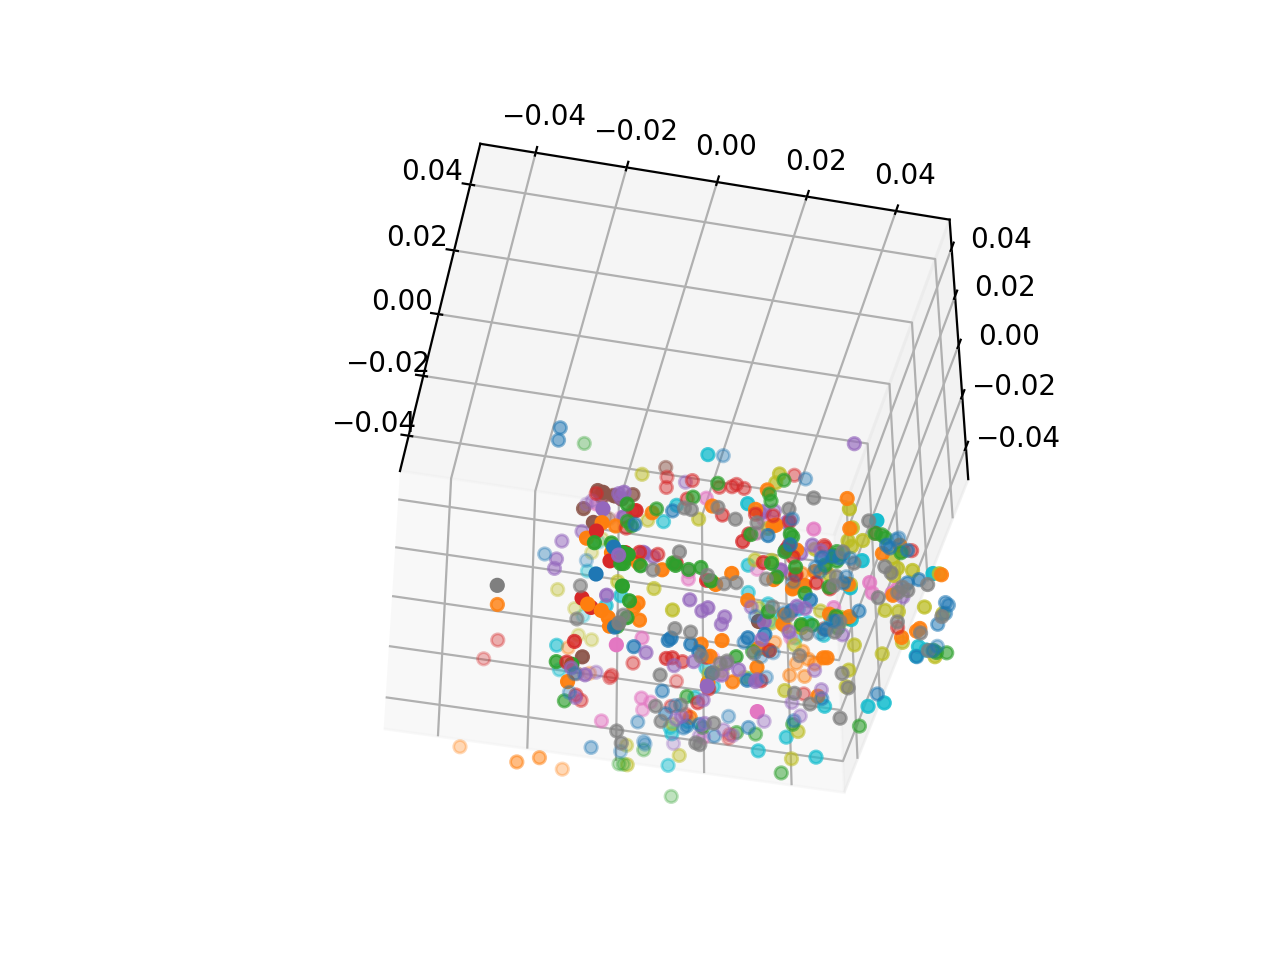

In [16]:
%matplotlib notebook
plot_all_triangulated(X_list, C_list = None, I_list = None, scale = 0.05)